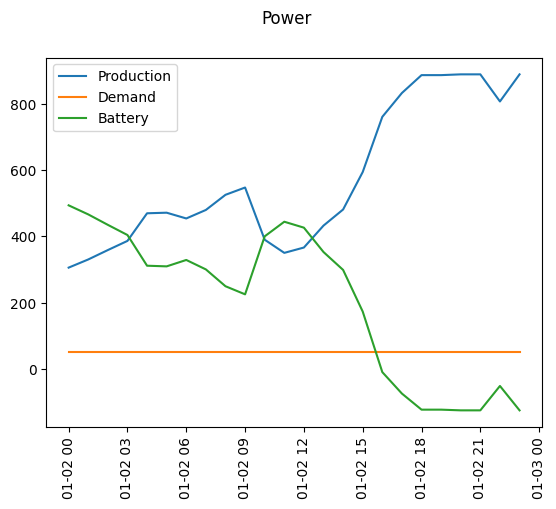

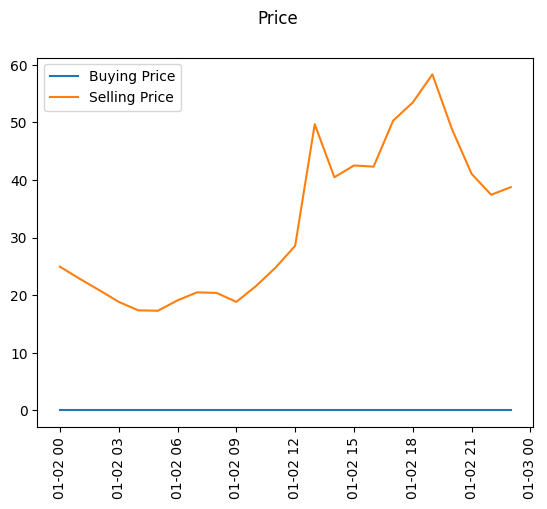

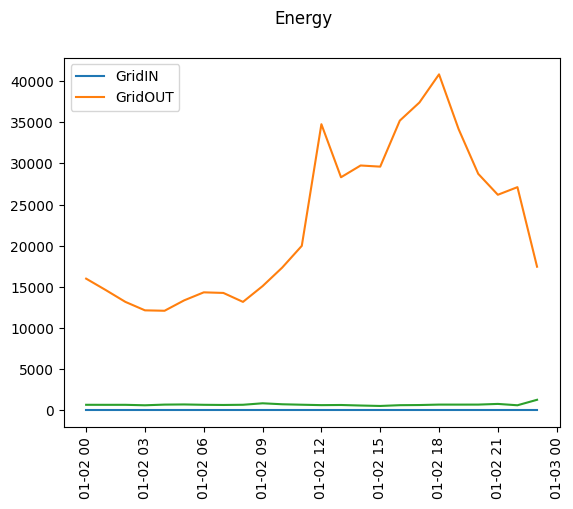

In [ ]:
import numpy as np
from scipy.optimize import LinearConstraint
from scipy.optimize import milp

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import datetime as dt
import math
from scipy.io import loadmat
from pandas import read_csv
import pandas as pd 
# import gurobipy as gp

mat1 = pd.read_csv('2019.csv')
mat2 = pd.read_csv('output_2030.csv')

Timestep = 1/2 #time Step in hour
Window = 24 # Optimization for half a day
Length = int(Window/Timestep) #number of data points
NdataConsidered = 48*6; #computation for the whole week
Start = 0;
IBCpercent = 0.51;  # Initial Battery Capacity (IBC)of 80#MacBcap
BatteryCapacity = [15000];#  Battery capacity
WHCRange = BatteryCapacity; # Range of Battery capacity in Watt-Hour (WH)
MinCapPercent = 0;
# # ##   Price computation
# # #Price Scheme of Energy Buying from Grid at Grid Buying Price (BP)
# HHBP = 20/100000;#20/100000; # High Hour Buying Price(HHBP),20Pence/kWh or O.2Pounds/kWh or 0.0002Pounds/Wh
# LHBP = 11/100000;#11/100000; # Low Hour Buying Price (LHBP, 11Pence/kWh or 0.11Pounds/kWh or 0.00011Pounds/Wh 
# #base1 = dt.datetime(2019,5,13)
# numminute1=1440
# Timeframe=list(range(1,1441))
# ##Timeframe = [base1 + dt.timedelta(minutes=x) for x in range(numminute1)] #creates an array with every minute of one day
# #Timeframe = (dt.datetime(2019,5,13):minutes(1):dt.datetime(2019,5,14))';# Timeframe.Format = 'dd-MM-yyyy HH:mm:ss';#T1-3 duration will change based on low & high hour pricing
# HHP1 = 7.5;
# HHP2 = 22.5;
# T1=Timeframe[:math.ceil(HHP1*60)+1]# python begins indexing at 0 and not 1 # Hours of  LHBP tariff 
# T2=Timeframe[math.ceil(HHP1*60)+1:math.ceil(HHP2*60)+1];# Hours of HHBP tariff
# T3 = Timeframe[math.ceil(HHP2*60)+1:1440];# Hours of LHBP tariff
# LHBP1 = LHBP*np.ones((len(T1),1));# Low buying price for all the hours
# HHBP1 = HHBP*np.ones((len(T2),1));# High buying price for all the hours
# LHBP2 = LHBP*np.ones((len(T3),1));# Low buying price for all the hours
# Daybuyprice1440Hrs = [*LHBP1,*HHBP1,*LHBP2];
# # # Price Scheme of Energy Selling to Grid at Grid Selling Price (SP)
# HHSP = 5.5/100000;#2/100000; # High Hour Selling Price(HHSP),2Pence/kWh or O.02Pounds/kWh or 0.00002Pounds/Wh
# LHSP = 5.4999/100000;#1.99/100000; # Low Hour Selling Price (LHSP),1.99Pence/kWh or O.0199Pounds/kWh or 0.0000199Pounds/Wh
# LHSP1 = LHSP*np.ones((len(T1),1));# Low selling price for all the hours
# HHSP1 = HHSP*np.ones((len(T2),1));# High selling price for all the hours
# LHSP2 = LHSP*np.ones((len(T3),1));# Low selling price for all the hours
# Daysellprice48Hrs = [*LHSP1,*HHSP1,*LHSP2];
# #base2 = dt.datetime(2019,5,13,00,00,00)
# numminute2=10080
# t=list(range(1,10081))
# ##t = [base2 + dt.timedelta(minutes=x) for x in range(numminute2)]
# # t = (datetime(2019,5,13,00,00,00):minutes(1):datetime(2019,5,19,23,59,00))';
# numminute3=337
# ttemp=list(range(1,337))
##ttemp = [base2 + dt.timedelta(minutes=x*30) for x in range(numminute3)]
# ttemp = (datetime(2019,5,13,00,00,00):minutes(Timestep*60):datetime(2019,5,20,00,00,00))';

# # Price Scheme of Energy Buying from Grid at Agile Octopus Grid Buying Price (BP)
# load Buying_Selling_Price; #Input of Daily Agile Octopus Buying Price (p/kWH)
AgileOctopusSP=mat2["price"]
AgileOctopusSP=AgileOctopusSP.iloc[0:24].values.reshape(24,-1)
AgileOctopusBP = np.zeros((24,1))

# load PVPower_Demand; # Input of computed wind power and demand
Porigin=mat1["output"].iloc[0:24] # Final wind power in Wh at one minute basis
Dorigin=mat1["SoloDemand"].iloc[0:24] # Final demand in Wh at one minute basis

# # Strategy-1&2 to determine: the State of Charge (SoC) of the battery,
# # total energy sold to grid and total energy bought from grid

BPorigin = AgileOctopusBP # Hourly grid buying price for one year
SPorigin = AgileOctopusSP # Hourly grid selling price for one year 

Ndata =len(Porigin)
# t2=list(range(1,338))
#t2 = (datetime(2019,5,13,00,00,00):minutes(30):datetime(2019,5,19,23,59,00))';
# j = 0;
P = Porigin.values;
D = Dorigin.values;

# for i in range(0,len(Porigin),30):
#      tmp = sum(Porigin[i:i+30])
#      P[j]= tmp[0]
#      tmp = sum(Dorigin[i:i+30])
#      D[j]= tmp[0]
#      sum(Dorigin[i:i+30])
#      j = j+1;

BP=BPorigin
SP=SPorigin
# BP = interp1(t,BPorigin,t2);
# SP = interp1(t,SPorigin,t2);

P = P[Start:Start+NdataConsidered];
D= D[Start:Start+NdataConsidered];
BP = BP[Start:Start+NdataConsidered];
SP = SP[Start:Start+NdataConsidered];
time = list(range(1,25));

Today=dt.datetime(2030,1,2,00,00,00)

timeenjour=[Today + dt.timedelta(minutes=60*x) for x in range(0, 24)]


DepreciationFactor =np.zeros(len(BatteryCapacity));
Batterycapacity =np.zeros(len(BatteryCapacity));
# ##optimization constraints
BPrice=BP[0:Length]
SPrice=SP[0:Length]
EfficiencyC = 0.9; # Battery Efficiency
EfficiencyD = 0.9;
k = 1;    
Pmax = 6*max(max(P),max(D));
MaxBcap = BatteryCapacity[k-1];# Maximum battery capcity in WHr [Variable Parameter]
MinBcap = MinCapPercent*MaxBcap*0.2;# Minimum battery capacity at 80# DoD
IBC = MaxBcap*IBCpercent; # Initial Battery Capacity (IBC)of 60#MacBcap
Pbatmax = 2*MaxBcap*Timestep;# max battery Power = 3.3kW# 3*max(P); #W  We consider there is no limit of battery power
SoCmax = BatteryCapacity[k-1]; #kWh 

SoC =np.zeros(len(P));
Energysold =np.zeros(len(P));
Energybought =np.zeros(len(P));
FromGrid =np.zeros(len(P));
ToGrid =np.zeros(len(P));
Dvariable = 1000*np.ones(len(P));
SoCmax = BatteryCapacity[k-1]; #kWh 
SoCmin = 0;
SoCInit = IBC; #kWh
Powerbat =np.zeros(len(P));
indice = 0;

## start optimisation
for i in range(0,len(P),Length):# we iterate every 24 hours for the whole week
    indice = indice +1;
    LengthOptim = min(i+Length,len(D))-i;  # Because the size of P might not be a multiple of the Length used for the optimization
    Demand = D[i:i+LengthOptim];
    Production = P[i:i+LengthOptim];
    BPrice = BP[i:i+LengthOptim];
    SPrice = SP[i:i+LengthOptim]; 
    f =np.r_[BPrice[:,0],-SPrice[:,0],np.zeros(LengthOptim),np.zeros(LengthOptim),np.zeros(LengthOptim),np.zeros(LengthOptim),np.zeros(LengthOptim),np.zeros(LengthOptim)]
    # f =np.r_([BPrice,-SPrice,np.zeros((LengthOptim,1)),np.zeros((LengthOptim,1)),np.zeros((LengthOptim,1)),np.zeros((LengthOptim,1)),np.zeros((LengthOptim,1)),np.zeros((LengthOptim,1))])

    Index_binary =np.array(list(range(len(f)-2*LengthOptim+1,len(f)+1))); #[121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144];
    Index_binary =np.r_[np.zeros(LengthOptim),np.zeros(LengthOptim),np.zeros(LengthOptim),np.zeros(LengthOptim),np.zeros(LengthOptim),np.zeros(LengthOptim),np.ones(LengthOptim),np.ones(LengthOptim)]

    Aeq1=np.c_[np.eye(LengthOptim), np.zeros((LengthOptim,LengthOptim)), EfficiencyD*np.eye(LengthOptim), -np.eye(LengthOptim)/EfficiencyC, -np.eye(LengthOptim),np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)), np.zeros((LengthOptim,LengthOptim))]
    Aeq2=np.c_[np.zeros((LengthOptim,LengthOptim)) ,np.eye(LengthOptim), -EfficiencyD*np.eye(LengthOptim) ,np.eye(LengthOptim)/EfficiencyC ,np.zeros((LengthOptim,LengthOptim)) ,-np.eye(LengthOptim),np.zeros((LengthOptim,LengthOptim)),np.zeros((LengthOptim,LengthOptim))]
    Aeq =np.concatenate([Aeq1,Aeq2],axis=0)
    Beq =np.concatenate([ Demand - Production , Production - Demand ],axis=0);
        
        
    A1=np.c_[np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,-Pmax*np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim))]
    A2=np.c_[np.zeros((LengthOptim,LengthOptim)) ,np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,Pmax*np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim))]
    A3=np.c_[np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.eye(LengthOptim) ,-Pmax*np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim))]
    A4=np.c_[np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim)) ,Pmax*np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim))]
    A5=np.c_[np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,-np.tril(np.ones((LengthOptim,LengthOptim))) ,np.tril(np.ones((LengthOptim,LengthOptim))) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim))]
    A6=np.c_[np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.tril(np.ones((LengthOptim,LengthOptim))) ,-np.tril(np.ones((LengthOptim,LengthOptim))) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim))]
    A7=np.c_[np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,-Pbatmax*np.eye(LengthOptim)]
    A8=np.c_[np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.eye(LengthOptim) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,np.zeros((LengthOptim,LengthOptim)) ,Pbatmax*np.eye(LengthOptim)]
    A =np.concatenate([A1,A2,A3,A4,A5,A6,A7,A8,Aeq, np.eye(f.shape[0])],axis=0)
    b = np.r_[np.zeros((LengthOptim,1)), Pmax*np.ones((LengthOptim,1)), np.zeros((LengthOptim,1)), Pmax*np.ones((LengthOptim,1)), (SoCmax-SoCInit)*np.ones((LengthOptim,1)), (SoCInit - SoCmin)*np.ones((LengthOptim,1)), np.zeros((LengthOptim,1)), Pbatmax*np.ones((LengthOptim,1))]
    lb =np.r_[np.zeros((LengthOptim,1)),np.zeros((LengthOptim,1)), np.zeros((LengthOptim,1)), np.zeros((LengthOptim,1)), np.zeros((LengthOptim,1)),  np.zeros((LengthOptim,1)),  np.zeros((LengthOptim,1)), np.zeros((LengthOptim,1))]
    ub = np.r_[Pmax*np.ones((LengthOptim,1)),700*np.ones((LengthOptim,1)), Pbatmax*np.ones((LengthOptim,1)),  Pbatmax*np.ones((LengthOptim,1)), Pmax*np.ones((LengthOptim,1)),  Pmax*np.ones((LengthOptim,1)),  np.ones((LengthOptim,1)),  np.ones((LengthOptim,1))]
    bu = np.concatenate([b[:,0],Beq, ub[:,0]],axis =0)
    bl = np.concatenate([-9e99*np.ones_like(b[:,0]),Beq, lb[:,0]],axis =0)
    # b=b[:,0]

    constraints = LinearConstraint(A, bl, bu)
    integrality = Index_binary

    res = milp(c=f, constraints=constraints, integrality=integrality)
    solution=res.x



    SoC[i:i+LengthOptim]=-np.tril(np.ones((LengthOptim,LengthOptim)))@solution[LengthOptim*2:LengthOptim*3]+np.tril(np.ones((LengthOptim,LengthOptim)))@solution[LengthOptim*3:LengthOptim*4]+SoCInit*np.ones((LengthOptim,1))[:,0]
    PgridIN=solution[0:LengthOptim]
    PgridOUT=solution[LengthOptim:LengthOptim*2]
    Pbat=solution[LengthOptim*2:LengthOptim*3]-solution[LengthOptim*3:LengthOptim*4]
    solution1 = solution[LengthOptim*4+1:LengthOptim*5]
    solution2 = solution[LengthOptim*5+1:LengthOptim*6]
    Alpha = solution[LengthOptim*6+1:LengthOptim*7]
    Beta = solution[LengthOptim*7+1:LengthOptim*8]
    SoCInit = SoC[i+LengthOptim-1];
    
    for j in range(0,LengthOptim):
        tmp = PgridIN[j]*BPrice[j]
        Energybought[i+j-1] = tmp[0]
        tmp = PgridOUT[j]*SPrice[j]
        Energysold[i+j-1] =tmp[0]
        FromGrid[i+j-1] = max(0,(D[i+j-1]-P[i+j-1]-max(0,Pbat[j])*EfficiencyD+max(0,-Pbat[j]/EfficiencyC)))
        ToGrid[i+j-1] = max(0, (P[i+j-1]-D[i+j-1]+max(0,Pbat[j]*EfficiencyD)-max(0,-Pbat[j]/EfficiencyC)))
        Powerbat [i:i+LengthOptim] = Pbat;

plt.figure(1)
plt.suptitle('Power')
plt.plot(timeenjour,P, timeenjour, D, timeenjour, Powerbat)
plt.legend(['Production', 'Demand','Battery'])
plt.xticks(rotation=90)
plt.show()
plt.figure(2)
plt.suptitle('Price')
plt.plot(timeenjour,BP, timeenjour, SP)
plt.legend(['Buying Price', 'Selling Price'])
plt.xticks(rotation=90)
plt.show()
plt.suptitle('Energy')
plt.plot(timeenjour,Energybought, timeenjour, Energysold, timeenjour, ToGrid)
plt.legend(['GridIN', 'GridOUT'])
plt.xticks(rotation=90)
plt.show()